In [247]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from utils import *
from IPython.display import display, HTML
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
40000 * 0.23 / 12

766.6666666666666

In [336]:
HGNC = pd.read_csv("/Users/jiayao/Work/Resources/protein-coding_gene.txt", delimiter="\t")
ENSID2Entrez = dict(zip(HGNC["ensembl_gene_id"].values, HGNC["entrez_id"].values))
GeneSymbol2Entrez = dict(zip(HGNC["symbol"].values, HGNC["entrez_id"].values))
Entrez2Symbol = dict(zip(HGNC["entrez_id"].values, HGNC["symbol"].values))
allen_mouse_genes = loadgenelist("../dat/allen-mouse-exp/allen-mouse-gene_entrez.txt")

str2reg_df = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/src/dat/structure2region.map", delimiter="\t")
str2reg_df = str2reg_df.sort_values("REG")
str2reg = dict(zip(str2reg_df["STR"].values, str2reg_df["REG"].values))

ExpMatNorm = "../dat/allen-mouse-exp/energy-neuronorm.csv"
ExpMatNorm = pd.read_csv(ExpMatNorm, index_col="ROW")

ExpMat1 = "../dat/allen-mouse-exp/energy-conn-model.csv"
ExpMat1 = pd.read_csv(ExpMat1, index_col="ROW")

ExpMat2 = "../dat/allen-mouse-exp/jon/energy-conn-model.csv"
ExpMat2 = pd.read_csv(ExpMat2, index_col="ROW")

ExpZscoreMat = "../dat/allen-mouse-exp/energy-zscore-conn-model.csv"
ExpZscoreMat = pd.read_csv(ExpZscoreMat, index_col="ROW")

ZscoreMatNorm = "../dat/allen-mouse-exp/energy-zscore-neuronorm.csv"
ZscoreMatNorm = pd.read_csv(ZscoreMatNorm, index_col="ROW")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (38,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Prenatal/Postnatal Bias Check

In [85]:
# Brain Span Gene Expresion process
GeneExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/expression_matrix.csv", header=None)
GeneExp = GeneExp.set_index(0)
for c in GeneExp.columns.values:
    GeneExp[c] = np.log2(1+GeneExp[c])
GeneExp = quantileNormalize(GeneExp)
GeneExp.to_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/log2.qn.expression_matrix.csv")

In [86]:
GeneExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/log2.qn.expression_matrix.csv")
GeneExp = GeneExp.set_index("0")
GeneExp.columns = [int(x) for x in GeneExp.columns.values]
GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/rows_metadata.csv")
GeneCol = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/columns_metadata.csv")
GeneCol["Period"] = GeneCol.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
GeneCol["Stage"] = GeneCol.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
GeneCol["Description"] = GeneCol.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
GeneDat = [GeneExp, GeneRow, GeneCol]

In [45]:
spark_tol = pd.read_csv("dat/bias/spark.explevel.rank.tsv", index_col="STR")
spark_tada = pd.read_csv("dat/bias/sparktada.norm.explevel.rank.tsv", index_col="STR")
asc_tada = pd.read_csv("dat/bias/asc.norm.explevel.rank.tsv", index_col="STR")

In [113]:
spark_tol_thalamus_strs = []
spark_tol_striatum_strs = []
spark_tol_isocortex_strs = []
for x in spark_tol.head(50).index:
    if str2reg[x] == "Thalamus":
        spark_tol_thalamus_strs.append(x)
    if str2reg[x] == "Striatum":
        spark_tol_striatum_strs.append(x)
    if str2reg[x] == "Isocortex":
        spark_tol_isocortex_strs.append(x)

In [114]:
print(spark_tol_thalamus_strs)
print(spark_tol_striatum_strs)
print(spark_tol_isocortex_strs)

['Lateral_posterior_nucleus_of_the_thalamus', 'Medial_geniculate_complex_dorsal_part', 'Rhomboid_nucleus', 'Parataenial_nucleus', 'Lateral_habenula', 'Lateral_dorsal_nucleus_of_thalamus', 'Medial_habenula', 'Intermediodorsal_nucleus_of_the_thalamus', 'Paraventricular_nucleus_of_the_thalamus']
['Caudoputamen', 'Nucleus_accumbens', 'Lateral_septal_nucleus_rostral_rostroventral_part', 'Fundus_of_striatum', 'Lateral_septal_nucleus_caudal_caudodorsal_part', 'Lateral_septal_nucleus_ventral_part', 'Olfactory_tubercle']
['Retrosplenial_area_lateral_agranular_part', 'Orbital_area_ventrolateral_part', 'Infralimbic_area', 'Frontal_pole_cerebral_cortex', 'Orbital_area_lateral_part', 'Prelimbic_area', 'Anterior_cingulate_area_dorsal_part', 'Orbital_area_medial_part', 'Secondary_motor_area', 'Anterior_cingulate_area_ventral_part', 'Anteromedial_visual_area', 'posteromedial_visual_area', 'Agranular_insular_area_ventral_part', 'Visceral_area', 'Agranular_insular_area_dorsal_part', 'Posterolateral_visu

In [46]:
for x in asc_tada.head(50).index:
    if str2reg[x] == "Thalamus":
        print(x)

Lateral_posterior_nucleus_of_the_thalamus
Lateral_dorsal_nucleus_of_thalamus
Rhomboid_nucleus
Dorsal_part_of_the_lateral_geniculate_complex


In [215]:
spark_tol_sg = pd.read_csv("dat/bias/spark.elevel.sg.csv")
spark_tol_sg = spark_tol_sg.set_index("STR")
#df.columns = [Entrez2Symbol[int(c)] for c in df.columns]

In [216]:
gene_names = []; thalamus_bias = []; striatum_bias = []; cortex_bias = [];
for entrez in spark_tol_sg.columns.values:
    target_thalamus = spark_tol_sg.loc[spark_tol_thalamus_strs, entrez]
    target_striatum = spark_tol_sg.loc[spark_tol_striatum_strs, entrez]
    target_cortex = spark_tol_sg.loc[spark_tol_isocortex_strs, entrez]
    
    thalamus_bias.append(np.mean([x for x in target_thalamus if x == x]))
    striatum_bias.append(np.mean([x for x in target_striatum if x == x]))
    cortex_bias.append(np.mean([x for x in target_cortex if x == x]))
    
    gene_names.append(Entrez2Symbol[int(entrez)])
    #print(target_thalamus)
    #break
    #print(c)

In [217]:
df = pd.DataFrame(data={"Entrez":spark_tol_sg.columns.values, "Name":gene_names, "Thalamus.Bias":thalamus_bias,
                       "Striatum.Bias":striatum_bias, "Cortex.Bias":cortex_bias})
df = df.sort_values("Thalamus.Bias", ascending=False)

In [221]:
for i, row in df.iterrows():
    try:
        df.loc[i, "lofZ"] = Gene2LoFZ[int(row["Entrez"])]
        df.loc[i, "pLI"] = Gene2pLI[int(row["Entrez"])]
    except:
        df.loc[i, "lofZ"] = 1
        df.loc[i, "pLI"] = 0

In [237]:
spark_tada = pd.read_csv("../dat/genes/TADA.SPARK.ONLY.txt", delimiter="\t")
spark_wigler = pd.read_csv("../dat/genes/spark_wiglermodel.csv")
spark_tada = spark_tada.sort_values("Qvalue")#.columns.values
spark_wigler = spark_wigler.sort_values("FDR")
tmp = spark_wigler[spark_wigler["FDR"]<0.2]
tmp2 = spark_tada[spark_tada["Qvalue"]<0.2]
sg_lgd_genes = set(tmp[tmp["MUT.TYPE"]=="lgd"]["SYMBOL"].values)
XX = set(sg_lgd_genes).difference(set(tmp2["HGNC"].values))

In [240]:
df2 = df[df["Name"].isin(XX)]

0.0669609654986933


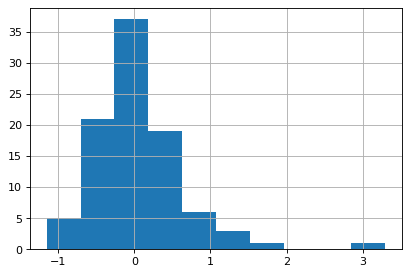

0.12377671933926493


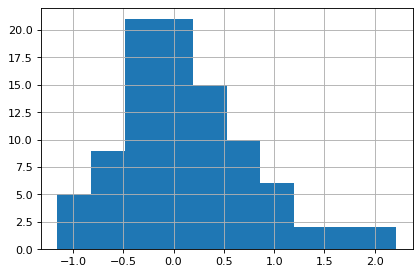

In [246]:
df2["Thalamus.Bias"].hist()
print(np.mean(df2["Thalamus.Bias"].values))
plt.show()
df2["Cortex.Bias"].hist()
print(np.mean(df2["Cortex.Bias"].values))
plt.show()

SpearmanrResult(correlation=0.05575146939086845, pvalue=0.335057321216114)


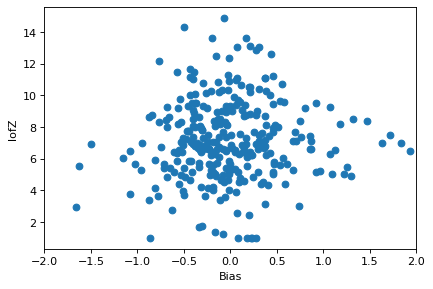

In [219]:
plt.scatter(df["Thalamus.Bias"].values, df["lofZ"].values)
print(spearmanr(df["Thalamus.Bias"].values, df["lofZ"].values))
plt.xlabel("Bias")
plt.ylabel("lofZ")
plt.xlim((-2, 2))
plt.show()

SpearmanrResult(correlation=nan, pvalue=nan)


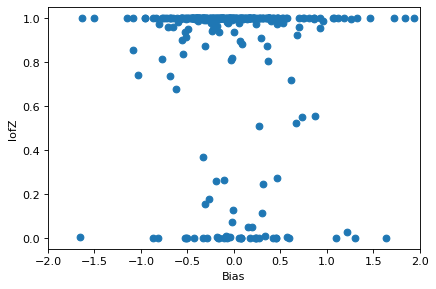

In [222]:
plt.scatter(df["Thalamus.Bias"].values, df["pLI"].values)
print(spearmanr(df["Thalamus.Bias"].values, df["pLI"].values))
plt.xlabel("Bias")
plt.ylabel("lofZ")
plt.xlim((-2, 2))
plt.show()

0.03221382768606158


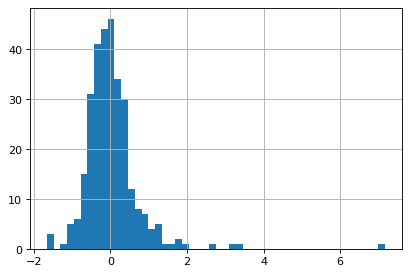

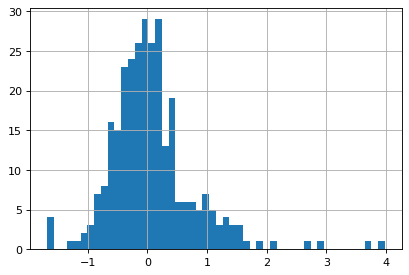

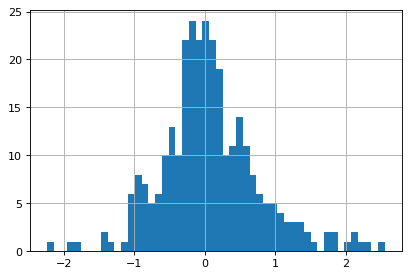

In [208]:
df["Thalamus.Bias"].hist(bins=50)
print(np.mean(df["Thalamus.Bias"].values))
plt.show()
df["Striatum.Bias"].hist(bins=50)
plt.show()
df["Cortex.Bias"].hist(bins=50)
plt.show()

In [209]:
spark_tad_sg = pd.read_csv("dat/bias/sparktada.elevel.sg.csv")
spark_tad_sg = spark_tad_sg.set_index("STR")

gene_names = []; thalamus_bias = []; striatum_bias = []; cortex_bias = [];
for entrez in spark_tad_sg.columns.values:
    target_thalamus = spark_tad_sg.loc[spark_tol_thalamus_strs, entrez]
    target_striatum = spark_tad_sg.loc[spark_tol_striatum_strs, entrez]
    target_cortex = spark_tad_sg.loc[spark_tol_isocortex_strs, entrez]
    
    thalamus_bias.append(np.mean([x for x in target_thalamus if x == x]))
    striatum_bias.append(np.mean([x for x in target_striatum if x == x]))
    cortex_bias.append(np.mean([x for x in target_cortex if x == x]))
    
    gene_names.append(Entrez2Symbol[int(entrez)])

df = pd.DataFrame(data={"Entrez":spark_tad_sg.columns.values, "Name":gene_names, "Thalamus.Bias":thalamus_bias,
                   "Striatum.Bias":striatum_bias, "Cortex.Bias":cortex_bias})
df = df.sort_values("Thalamus.Bias", ascending=False)

In [210]:
df.head(2)

,Entrez,Name,Thalamus.Bias,Striatum.Bias,Cortex.Bias
76,6934,TCF7L2,6.987713,-1.343804,-2.285960
59,1499,CTNNB1,1.941358,-0.065499,-0.424604


In [223]:
gnomad_cons = pd.read_csv("/Users/jiayao/Work/Resources/gnomad.v2.1.1.lof_metrics.by_gene.txt", delimiter="\t")
Gene2LoFZ = {}
Gene2pLI = {}
for i, row in gnomad_cons.iterrows():
    try:
        Gene2LoFZ[GeneSymbol2Entrez[row["gene"]]] = row["lof_z"] #max(1, row["lof_z"] + 1)
        Gene2pLI[GeneSymbol2Entrez[row["gene"]]] = row["pLI"]
    except:
        continue
for i, row in df.iterrows():
    try:
        df.loc[i, "lofZ"] = Gene2LoFZ[int(row["Entrez"])]
    except:
        df.loc[i, "lofZ"] = 1

In [232]:
np.var([x for x in list(Gene2LoFZ.values()) if x==x])
np.mean([x for x in list(Gene2LoFZ.values()) if x==x])

2.227398684563078

SpearmanrResult(correlation=0.06439256639904593, pvalue=0.5099325222550456)


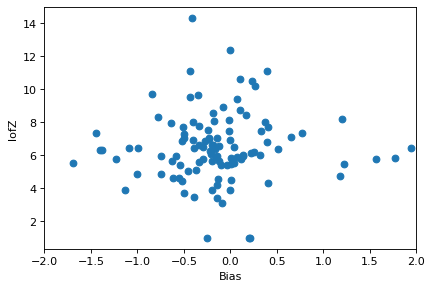

In [212]:
plt.scatter(df["Thalamus.Bias"].values, df["lofZ"].values)
print(spearmanr(df["Thalamus.Bias"].values, df["lofZ"].values))
plt.xlabel("Bias")
plt.ylabel("lofZ")
plt.xlim((-2, 2))
plt.show()

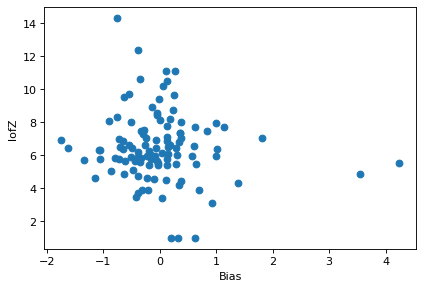

In [213]:
plt.scatter(df["Striatum.Bias"].values, df["lofZ"].values)
plt.xlabel("Bias")
plt.ylabel("lofZ")
plt.show()

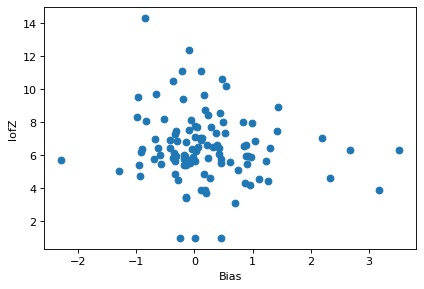

In [214]:
plt.scatter(df["Cortex.Bias"].values, df["lofZ"].values)
plt.xlabel("Bias")
plt.ylabel("lofZ")
plt.show()

-0.0778260697999025


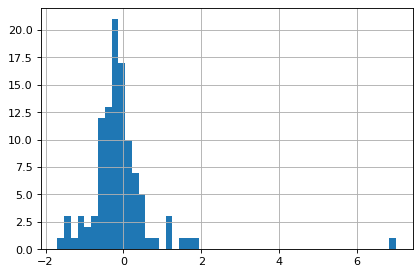

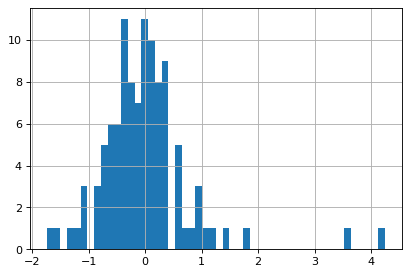

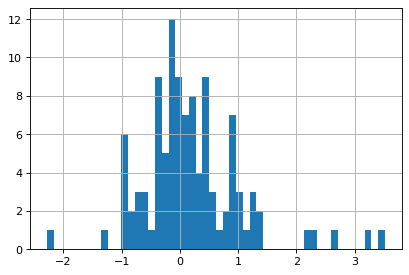

In [177]:
df["Thalamus.Bias"].hist(bins=50)
print(np.mean(df["Thalamus.Bias"].values))
plt.show()
df["Striatum.Bias"].hist(bins=50)
plt.show()
df["Cortex.Bias"].hist(bins=50)
plt.show()

In [162]:
thalamus_biased_genes = df[df["Thalamus.Bias"]>0]["Name"].values
straitum_biased_genes = df[df["Striatum.Bias"]>0]["Name"].values
cortex_biased_genes = df[df["Cortex.Bias"]>0]["Name"].values

In [163]:
print(thalamus_biased_genes)
print(straitum_biased_genes)
print(cortex_biased_genes)

['TCF7L2' 'ZNF423' 'GRM1' 'ZFHX3' 'CTNNB1' 'CTNND1' 'KIF26B' 'AGRN'
 'LRRC7' 'PPFIA2' 'ABLIM3' 'CNNM2' 'HID1' 'SMARCC2' 'NDST1' 'HEG1'
 'COL1A1' 'STT3B' 'RTN1' 'RCC2' 'TENM2' 'THBS2' 'KCNMA1' 'TRIM28' 'NRXN1'
 'KDM3B' 'SHANK3' 'TMEM131' 'MORN4' 'RFX3' 'KIAA0922' 'EXOC3' 'TNR'
 'ZNF469' 'MAP4K2' 'ZNF462' 'PITPNM1' 'SPTBN1' 'PRRC2A' 'CDC40' 'ASXL3'
 'XPO1' 'SMARCD1' 'CLCN7' 'MYT1L' 'SPEN' 'ATXN1' 'LLGL1' 'PLEC' 'TNRC18'
 'PCLO' 'CACNA1H' 'SPTB' 'KIF5A' 'ACTB' 'ANAPC2' 'CACNA1E' 'UPF2' 'POLR2A'
 'BPTF' 'PIK3CD' 'CHD8' 'AUTS2' 'H3F3B' 'AHR' 'BTBD2' 'AHDC1' 'DHX30'
 'RIPK1' 'GRIN2B' 'NEO1' 'FAT4' 'HERC2' 'PNN' 'CDK13' 'RALGAPA1' 'ZSWIM8'
 'SMG1' 'LRP5' 'TSPOAP1' 'SETD5' 'B4GALNT4' 'CAPRIN1' 'CRAMP1' 'BICRA'
 'DLL1' 'MED13' 'CHD2' 'DICER1' 'CLK2' 'WDFY3' 'KMT2B' 'C1QC' 'DYRK1A'
 'EEF2' 'KCNB1' 'KMT5B' 'SON' 'EPS15L1' 'KDM4B' 'KMT2C' 'TSC2' 'BRD1'
 'HIVEP1' 'CBFA2T3' 'PACS2' 'PTPRA' 'DSCAM' 'EP300' 'ARID1A' 'MSL3' 'AFF4'
 'CACTIN' 'MED26' 'KAT6A' 'PDE3A' 'NSD2' 'WTIP' 'HECTD4' 'CHD6' 'ARID1B'

In [164]:
selected_genes = GeneRow[GeneRow["gene_symbol"].isin(thalamus_biased_genes)]["row_num"].values

In [165]:
selected_genes

array([   92,   229,   508,   657,   675,   943,   948,   960,   971,
        1009,  1113,  1133,  1201,  1328,  1330,  1462,  1491,  1505,
        1595,  1603,  2067,  2315,  2327,  2392,  2420,  2434,  2756,
        2802,  2812,  3057,  3353,  3578,  3630,  3839,  4445,  4578,
        4797,  5138,  5189,  5519,  5581,  5640,  5895,  5982,  5999,
        6124,  6255,  6386,  6576,  6607,  6663,  6700,  6804,  6962,
        7135,  7521,  7871,  7924,  7977,  8103,  8188,  8305,  9142,
        9224,  9237,  9375,  9502,  9689,  9787,  9912, 10037, 10054,
       10172, 10224, 10318, 10329, 10415, 10425, 10808, 10828, 10969,
       11166, 11203, 12299, 12412, 12421, 12440, 12510, 12656, 13159,
       13266, 13272, 13278, 13509, 13638, 13716, 13746, 13864, 14241,
       14286, 14664, 14823, 14893, 14988, 15000, 15031, 15251, 15408,
       15458, 16538, 16572, 16577, 16973, 17361, 17517, 18110, 18223,
       18283, 20599, 28324, 45467])

In [166]:
def gene_set_profile(geneset, GeneExp=GeneExp, GeneRow=GeneRow, GeneCol=GeneCol):
    selected_genes = GeneRow[GeneRow["gene_symbol"].isin(geneset)]["row_num"].values
    Regions = GeneCol["structure_acronym"].values
    gene_set_res = []
    for gene_row in selected_genes:
        gene_res = []
        for stage in Stages:
            cols = GeneCol[(GeneCol["Period"]==stage) & (GeneCol["structure_acronym"].isin(Regions))]["column_num"].values
            exp_values = GeneExp.loc[gene_row, cols]
            exp_values = [x for x in exp_values if x==x]
            gene_res.append(np.mean(exp_values))
        gene_set_res.append(gene_res)
    gene_set_res = np.array(gene_set_res)
    return gene_set_res

1.108086588028641


Text(0.5, 1.0, 'Thalamus')

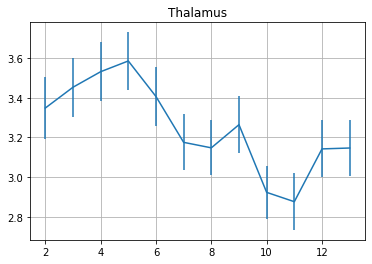

In [167]:
thalamus_profile = gene_set_profile(thalamus_biased_genes)
res = []; std=[]
for i, stage in enumerate(Stages):
    point = thalamus_profile[:,i]
    res.append(np.mean(point))
    std.append(np.std(point)/math.sqrt(len(point)))
print(np.mean(res[:6])/np.mean(res[6:]))
plt.errorbar(range(2,14), res, yerr=std)
plt.grid(True)
plt.title("Thalamus")

1.1249475733626488


Text(0.5, 1.0, 'Striatum')

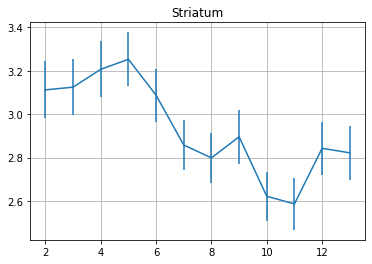

In [168]:
straitum_profile = gene_set_profile(straitum_biased_genes)
res = []; std=[]
for i, stage in enumerate(Stages):
    point = straitum_profile[:,i]
    res.append(np.mean(point))
    std.append(np.std(point)/math.sqrt(len(point)))
print(np.mean(res[:6])/np.mean(res[6:]))
plt.errorbar(range(2,14), res, yerr=std)
plt.grid(True)
plt.title("Striatum")

1.1052672250299485


Text(0.5, 1.0, 'Cortex')

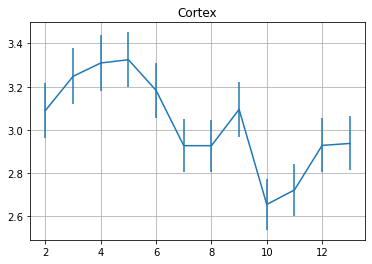

In [169]:
cortex_profile = gene_set_profile(cortex_biased_genes)
res = []; std=[]
for i, stage in enumerate(Stages):
    point = cortex_profile[:,i]
    res.append(np.mean(point))
    std.append(np.std(point)/math.sqrt(len(point)))
print(np.mean(res[:6])/np.mean(res[6:]))
plt.errorbar(range(2,14), res, yerr=std)
plt.grid(True)
plt.title("Cortex")          

## Remove Top Constraint genes and see thalamical bias

In [251]:
# Constraint 
gnomad_cons = pd.read_csv("/Users/jiayao/Work/Resources/gnomad.v2.1.1.lof_metrics.by_gene.txt", delimiter="\t")
Gene2LoFZ = {}
Gene2pLI = {}
for i, row in gnomad_cons.iterrows():
    try:
        Gene2LoFZ[GeneSymbol2Entrez[row["gene"]]] = row["lof_z"]#max(1, row["lof_z"] + 1)
        Gene2pLI[GeneSymbol2Entrez[row["gene"]]] = row["pLI"]
    except:
        continue

In [307]:
GeneSymbol2Entrez

{'A1BG': 1.0,
 'A1CF': 29974.0,
 'A2M': 2.0,
 'A2ML1': 144568.0,
 'A3GALT2': 127550.0,
 'A4GALT': 53947.0,
 'A4GNT': 51146.0,
 'AAAS': 8086.0,
 'AACS': 65985.0,
 'AADAC': 13.0,
 'AADACL2': 344752.0,
 'AADACL3': 126767.0,
 'AADACL4': 343066.0,
 'AADAT': 51166.0,
 'AAED1': 195827.0,
 'AAGAB': 79719.0,
 'AAK1': 22848.0,
 'AAMDC': 28971.0,
 'AAMP': 14.0,
 'AANAT': 15.0,
 'AAR2': 25980.0,
 'AARD': 441376.0,
 'AARS': 16.0,
 'AARS2': 57505.0,
 'AARSD1': 80755.0,
 'AASDH': 132949.0,
 'AASDHPPT': 60496.0,
 'AASS': 10157.0,
 'AATF': 26574.0,
 'AATK': 9625.0,
 'ABAT': 18.0,
 'ABCA1': 19.0,
 'ABCA2': 20.0,
 'ABCA3': 21.0,
 'ABCA4': 24.0,
 'ABCA5': 23461.0,
 'ABCA6': 23460.0,
 'ABCA7': 10347.0,
 'ABCA8': 10351.0,
 'ABCA9': 10350.0,
 'ABCA10': 10349.0,
 'ABCA12': 26154.0,
 'ABCA13': 154664.0,
 'ABCB1': 5243.0,
 'ABCB4': 5244.0,
 'ABCB5': 340273.0,
 'ABCB6': 10058.0,
 'ABCB7': 22.0,
 'ABCB8': 11194.0,
 'ABCB9': 23457.0,
 'ABCB10': 23456.0,
 'ABCB11': 8647.0,
 'ABCC1': 4363.0,
 'ABCC2': 1244.0,
 'ABCC

In [286]:
ssc_wigler = ssc = pd.read_excel("../dat/genes/pnas.1516376112.sd01.xlsx", sheet_name="ST1-genes-beautified")

In [310]:
ssc_wigler["Entrez"] = [GeneSymbol2Entrez.get(x, 0) for x in ssc_wigler["gene"].values]
ssc_wigler = ssc_wigler[ssc_wigler["Entrez"]!=0].dropna(subset=["Entrez"])
#ssc_wigler["Entrez"] = [int(x) for x in ssc_wigler["Entrez"].values]
ssc_wigler = ssc_wigler.set_index("Entrez")
Lost_Gene = 0
for i, row in ssc_wigler.iterrows():
    try:
    #print(i)
        ssc_wigler.loc[i, "lof_z"] = Gene2LoFZ[int(i)]
        ssc_wigler.loc[i, "pLI"] = Gene2pLI[int(i)]
    except:
        #print(i, row["SYMBOL"])
        Lost_Gene += 1
Lost_Gene

249

In [309]:
ssc_wigler.head(5)

,gene,codingLen,codingLenInTarget,chromosome,set_FMRPTargets,set_PSD,set_Embryonic,set_ChromatinModifiers,set_EssentialGenes,set_HLA,...,GR_PUB_missense_oC,GR_PUB_missense_eC,GR_PUB_LGDs_oC,GR_PUB_LGDs_eC,GR_PUB_LGDs_post,GR_PUBNOAUT_LGDs_oC,GR_PUBNOAUT_LGDs_eC,GR_PUBNOAUT_LGDs_post,lof_z,pLI
Entrez,,,,,,,,,,,,,,,,,,,,,
29123.0,ANKRD11,7992,7992,16,1,0,0,0,1,0,...,206,324.360067,0,10.454,1.000,0,7.824,1.000,8.1680,1.0
4035.0,LRP1,13635,13635,12,1,1,0,0,1,0,...,314,528.571905,1,15.010,1.000,0,11.180,1.000,14.0900,1.0
1826.0,DSCAM,6039,6039,21,1,0,0,0,1,0,...,120,192.457225,1,7.175,0.998,0,5.373,0.999,8.0664,1.0
4297.0,KMT2A,11919,11919,11,0,0,0,0,0,0,...,182,203.376705,1,7.412,0.999,0,5.554,0.999,11.3810,1.0
8295.0,TRRAP,11580,11513,7,1,0,1,1,1,0,...,184,380.642911,0,11.684,1.000,0,8.738,0.999,12.5930,1.0


In [304]:
ssc_wigler_tops = ssc_wigler[ssc_wigler["GR_PUBNOAUT_LGDs_post"]>0.8].sort_values("lof_z", ascending=False)
ssc_wigler_tops.shape

(234, 74)

In [311]:
ssc_wigler_match_df.head(2)

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
GENE,,,,,,,,,,,,,,,,,,,,,
29123,388403,11083,27072,782,140467,57181,7419,29123,221545,1351,...,81565,140707,23304,59353,9879,10971,221545,726,54329,55621
10438,121355,79781,10160,147111,162993,29920,23569,374907,2018,29777,...,23244,84287,10507,29777,644186,113612,79781,340351,162993,23244


In [313]:
ssc_wigler_tops.index = [int(x) for x in ssc_wigler_tops.index.values]
ssc_wigler_tops = ssc_wigler_tops[ssc_wigler_tops.index.isin(ssc_wigler_match_df.index.values)]
ssc_wigler_tops.shape

(212, 74)

In [342]:
ssc_wigler_zscore = ZscoreAVGWithExpMatch(ExpZscoreMat, ssc_wigler_tops.index.values, 
                                      ssc_wigler_match_df, csv_fil="dat/bias/sscwigler.zscore.csv")
RegionDistributions(ssc_wigler_zscore.head(50).set_index("STR"))

Cerebellum 	 3 	 Culmen; Pyramus_VIII; Simple_lobule
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Pallidum 	 2 	 Triangular_nucleus_of_septum; Bed_nuclei_of_the_stria_terminalis
Cortical_subplate 	 2 	 Claustrum; Posterior_amygdalar_nucleus
Hippocampal_formation 	 3 	 Parasubiculum; Subiculum_dorsal_part; Presubiculum
Isocortex 	 10 	 Infralimbic_area; Orbital_area_ventrolateral_part; Frontal_pole_cerebral_cortex; Orbital_area_lateral_part; Retrosplenial_area_lateral_agranular_part; Prelimbic_area; Secondary_motor_area; Anterior_cingulate_area_ventral_part; posteromedial_visual_area; Retrosplenial_area_dorsal_part
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta
Thalamus 	 12 	 Lateral_posterior_nucleus_of_the_thalamus; Lateral_habenula; Parataenial_nucleus; Medial_habenula; Submedial_nucleus_of_the_thalamus; Nucleus_of_reuniens; Intermediodorsal_nucleus_of_the_thalamus; Mediod

In [343]:
ssc_wigler_zscore = ZscoreAVGWithExpMatch(ZscoreMatNorm, ssc_wigler_tops.index.values, 
                                      ssc_wigler_match_df, csv_fil="dat/bias/sscwigler.zscore.neuronorm.csv")
RegionDistributions(ssc_wigler_zscore.head(50).set_index("STR"))

Cerebellum 	 3 	 Culmen; Pyramus_VIII; Simple_lobule
Midbrain 	 4 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Superior_colliculus_sensory_related; Inferior_colliculus_central_nucleus
Pallidum 	 2 	 Bed_nuclei_of_the_stria_terminalis; Triangular_nucleus_of_septum
Cortical_subplate 	 3 	 Claustrum; Basomedial_amygdalar_nucleus; Endopiriform_nucleus_dorsal_part
Hippocampal_formation 	 3 	 Parasubiculum; Subiculum_dorsal_part; Presubiculum
Isocortex 	 13 	 Infralimbic_area; Orbital_area_ventrolateral_part; Frontal_pole_cerebral_cortex; Orbital_area_lateral_part; Retrosplenial_area_lateral_agranular_part; Prelimbic_area; Anterior_cingulate_area_ventral_part; posteromedial_visual_area; Secondary_motor_area; Posterolateral_visual_area; Retrosplenial_area_dorsal_part; Anterior_cingulate_area_dorsal_part; Anteromedial_visual_area
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta
Thalamus 	 6 	 Late

In [323]:
ssc_wigler_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")
ssc_wigler_elevel = ExpAVGWithExpMatch(ExpMatNorm, ssc_wigler_tops.index.values, 
                                      ssc_wigler_match_df, csv_fil="dat/bias/sscwigler.neuronorm.csv")

In [324]:
RegionDistributions(ssc_wigler_elevel.head(50).set_index("STR"))

Cerebellum 	 3 	 Culmen; Pyramus_VIII; Simple_lobule
Midbrain 	 5 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Inferior_colliculus_central_nucleus; Superior_colliculus_sensory_related; Inferior_colliculus_dorsal_nucleus
Pallidum 	 2 	 Triangular_nucleus_of_septum; Bed_nuclei_of_the_stria_terminalis
Cortical_subplate 	 2 	 Claustrum; Endopiriform_nucleus_dorsal_part
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Parasubiculum
Isocortex 	 15 	 Orbital_area_ventrolateral_part; Infralimbic_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_lateral_part; Frontal_pole_cerebral_cortex; Prelimbic_area; Anterior_cingulate_area_ventral_part; Secondary_motor_area; posteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Posterolateral_visual_area; Retrosplenial_area_dorsal_part; Anteromedial_visual_area; Agranular_insular_area_ventral_part; Primary_visual_area
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal

In [ ]:


ssc_wigler_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")
ssc_wigler_elevel = ExpAVGWithExpMatch(ExpMat1, ssc_wigler_tops.index.values, 
                                      ssc_wigler_match_df, csv_fil="dat/bias/sscwigler.expmatV1.csv")

In [325]:
ssc_wigler_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")
ssc_wigler_elevel = ExpAVGWithExpMatch(ExpMat1, ssc_wigler_tops.index.values, 
                                      ssc_wigler_match_df, csv_fil="dat/bias/sscwigler.expmatV1.csv")

In [326]:
RegionDistributions(ssc_wigler_elevel.head(50).set_index("STR"))

Cerebellum 	 2 	 Culmen; Pyramus_VIII
Midbrain 	 4 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Inferior_colliculus_central_nucleus; Superior_colliculus_sensory_related
Cortical_subplate 	 1 	 Claustrum
Hippocampal_formation 	 2 	 Parasubiculum; Subiculum_dorsal_part
Isocortex 	 12 	 Orbital_area_ventrolateral_part; Infralimbic_area; Retrosplenial_area_lateral_agranular_part; Orbital_area_lateral_part; Prelimbic_area; Retrosplenial_area_dorsal_part; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_ventral_part; Anterior_cingulate_area_dorsal_part; Secondary_motor_area; posteromedial_visual_area; Anteromedial_visual_area
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Taenia_tecta; Dorsal_peduncular_area
Thalamus 	 14 	 Lateral_posterior_nucleus_of_the_thalamus; Parataenial_nucleus; Submedial_nucleus_of_the_thalamus; Nucleus_of_reuniens; Central_medial_nucleus_of_the_thalamus; Lateral_habenula; Rhomboid_nucleus; Intermed

In [327]:
ssc_wigler_match_df = pd.read_csv("dat/matching/asd_ssc_exp_matches_1000.csv", index_col="GENE")
ssc_wigler_elevel = ExpAVGWithExpMatch(ExpMat2, ssc_wigler_tops.index.values, 
                                      ssc_wigler_match_df, csv_fil="dat/bias/sscwigler.expmatV2.csv")

In [328]:
RegionDistributions(ssc_wigler_elevel.head(50).set_index("STR"))

Cerebellum 	 3 	 Culmen; Pyramus_VIII; Simple_lobule
Midbrain 	 4 	 Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract; Inferior_colliculus_central_nucleus; Superior_colliculus_sensory_related
Pallidum 	 2 	 Triangular_nucleus_of_septum; Bed_nuclei_of_the_stria_terminalis
Cortical_subplate 	 1 	 Claustrum
Hippocampal_formation 	 2 	 Subiculum_dorsal_part; Parasubiculum
Isocortex 	 13 	 Infralimbic_area; Orbital_area_ventrolateral_part; Retrosplenial_area_lateral_agranular_part; Orbital_area_lateral_part; Prelimbic_area; Frontal_pole_cerebral_cortex; Anterior_cingulate_area_ventral_part; Retrosplenial_area_dorsal_part; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; posteromedial_visual_area; Anteromedial_visual_area; Posterolateral_visual_area
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Anterior_olfactory_nucleus; Main_olfactory_bulb; Dorsal_peduncular_area; Taenia_tecta
Thalamus 	 10 	 Lateral_posterior_nucleus_of_the_thalamus; Lateral_habenula; Parataenial_nucleus;

In [273]:
Spark_wigler = pd.read_csv("../dat/genes/spark_wiglermodel.csv")
Spark_wigler = Spark_wigler.dropna(subset=["GENE"]).set_index("GENE").drop_duplicates(subset="SYMBOL", keep='first')
Spark_wigler.index = [int(x) for x in Spark_wigler.index.values]
Spark_wigler = Spark_wigler.sort_values("FDR")
Lost_Gene = 0
for i, row in Spark_wigler.iterrows():
    try:
    #print(i)
        Spark_wigler.loc[i, "lof_z"] = Gene2LoFZ[int(i)]
        Spark_wigler.loc[i, "pLI"] = Gene2pLI[int(i)]
    except:
        #print(i, row["SYMBOL"])
        Lost_Gene += 1
Lost_Gene

123

In [274]:
spark_wigler_tops = Spark_wigler[Spark_wigler["FDR"]<0.2].sort_values("lof_z", ascending=False)
spark_wigler_tops.shape

(318, 13)

In [275]:
spark_wigler_tops

,MUT.TYPE,A.D,nA.D,OBS.SYN,EXP,OBS,R.A,R.nA,A.DR,FDR,SYMBOL,lof_z,pLI
23499,lgd,0.43,0.57,176.0,7.725,0.0,0.461857,0.000442,0.998734,0.001266,MACF1,15.611,1.0
23352,rec.mis,0.35,0.65,209.0,8.769,2.0,0.159970,0.005978,0.935105,0.064895,UBR4,13.866,1.0
1778,rec.lgd,0.90,0.10,196.0,8.364,2.0,0.151549,0.008154,0.994057,0.005943,DYNC1H1,13.319,1.0
8295,rec.mis,0.35,0.65,208.0,8.738,0.0,0.417363,0.000160,0.999287,0.000713,TRRAP,12.593,1.0
58508,rec.lgd,0.90,0.10,162.0,7.242,2.0,0.127107,0.018773,0.983855,0.016145,KMT2C,12.592,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114784,lgd,0.43,0.57,196.0,8.364,2.0,0.151549,0.008154,0.933428,0.066572,CSMD2,NaN,NaN
9858,rec.mis,0.35,0.65,51.0,3.363,0.0,0.714409,0.034631,0.917410,0.082590,PPP1R26,NaN,NaN
51111,rec.lgd,0.90,0.10,26.0,2.294,1.0,0.182375,0.231378,0.876451,0.123549,KMT5B,NaN,NaN
29998,lgd,0.43,0.57,29.0,2.461,0.0,0.781844,0.085350,0.873586,0.126414,BICRA,NaN,NaN


In [279]:
asd_sparkwigler_match_df = pd.read_csv("dat/matching/asd_spark_exp_matches_1000.csv", index_col="GENE")
asd_sparkwigler_elevel = ExpAVGWithExpMatch(ExpMatNorm, spark_wigler_tops.index.values, 
                                      asd_sparkwigler_match_df, csv_fil="dat/bias/sparkwigler.test.csv")

In [285]:
RegionDistributions(asd_sparkwigler_elevel.head(100).set_index("STR"))

Cerebellum 	 2 	 Ansiform_lobule; Pyramus_VIII
Pallidum 	 2 	 Triangular_nucleus_of_septum; Bed_nuclei_of_the_stria_terminalis
Cortical_subplate 	 5 	 Claustrum; Endopiriform_nucleus_dorsal_part; Posterior_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus
Isocortex 	 18 	 Infralimbic_area; Retrosplenial_area_lateral_agranular_part; Frontal_pole_cerebral_cortex; Orbital_area_ventrolateral_part; Prelimbic_area; Orbital_area_lateral_part; Anterior_cingulate_area_dorsal_part; Orbital_area_medial_part; Secondary_motor_area; Anterior_cingulate_area_ventral_part; Posterolateral_visual_area; Visceral_area; Anteromedial_visual_area; posteromedial_visual_area; Agranular_insular_area_ventral_part; Supplemental_somatosensory_area; Agranular_insular_area_dorsal_part; Gustatory_areas
Olfactory_areas 	 5 	 Accessory_olfactory_bulb; Dorsal_peduncular_area; Anterior_olfactory_nucleus; Main_olfactory_bulb; Taenia_tecta
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus